In [1]:
import torch.nn as nn
import torch
from torch.utils.data import *
import os
import numpy as np
from util.measure_utils import *
from util.common_utils import *
from util.visual_utils import *
from util.gaussian_util import *
from torchvision import transforms
import random

/home/ayw/anaconda3/envs/torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 9, kernel_size= 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=32, kernel_size= 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size= 4, padding=2, stride=4)
        self.conv4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size= 4, padding=2, stride=2)
        self.linear1 = nn.Linear(39*64, 64)
        self.linear2 = nn.Linear(64, 2)
        self.relu = nn.LeakyReLU()
        self.f = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.reshape(x.shape[0],x.shape[1],  -1)
        return (self.f(self.linear2(self.relu(self.linear1(x)))))[0]

In [27]:
class Train(Dataset):
    def __init__(self):
        self.path = '../data/full'
        self.datalist = []
        self.crop = transforms.CenterCrop(size=[300, 500])
        for img_path in os.listdir(self.path):
            self.datalist.append(img_path)

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        origin_path = self.datalist[idx]
        origin = Image.open(os.path.join(self.path, origin_path))
        sigma = 25
        sigma_ = sigma/255.
        img_noisy_pil, img_noisy_np = get_noisy_image(pil_to_np(origin), sigma_)
        origin_pil = self.crop(origin)
        img_noisy_pil = self.crop(img_noisy_pil)
        return pil_to_np(origin_pil), pil_to_np(img_noisy_pil), np.array([1.0,0.0]), np.array([0.0,1.0])

In [28]:
class Valid(Dataset):
    def __init__(self):
        self.path = '../data/test'
        self.datalist = []
        self.crop = transforms.CenterCrop(size=[300, 500])
        for img_path in os.listdir(self.path):
            self.datalist.append(img_path)

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        origin_path = self.datalist[idx]
        origin = Image.open(os.path.join(self.path, origin_path))
        sigma = 25
        sigma_ = sigma/255.
        img_noisy_pil, img_noisy_np = get_noisy_image(pil_to_np(origin), sigma_)
        origin_pil = self.crop(origin)
        img_noisy_pil = self.crop(img_noisy_pil)
        return pil_to_np(origin_pil), pil_to_np(img_noisy_pil), np.array([1.0,0.0]), np.array([0.0,1.0])

In [32]:
dtype = torch.float32
training_data = Train()
test_data = Valid()
train_dataloader = DataLoader(training_data, batch_size=1)
test_dataloader = DataLoader(test_data, batch_size=1)
net = D().type(dtype)
net = net.cuda()
mse = torch.nn.MSELoss().type(dtype)

In [35]:
epoch = 0
def closure():
    global epoch
    for i, data in enumerate(train_dataloader):
        origin, noise, origin_label, noise_label = data
        origin_t = origin.type(dtype).cuda()
        noise_t = noise.type(dtype).cuda()
        origin_label = origin_label.type(dtype).cuda()
        noise_label =noise_label.type(dtype).cuda()
        output1 = net(origin_t)
        output2 = net(noise_t)
        total_loss = mse(output1, origin_label) + mse(output2, noise_label)
        total_loss.backward()

    total_clean_loss = 0
    total_noise_loss = 0
    accuracy = 0
    for i,data in enumerate(test_dataloader):
        with torch.no_grad():
            origin, noise, origin_label, noise_label = data
            origin_t = origin.type(dtype).cuda()
            noise_t = noise.type(dtype).cuda()
            origin_label = origin_label.type(dtype).cuda()
            noise_label =noise_label.type(dtype).cuda()
            output1 = net(origin_t)
            output2 = net(noise_t)
            clean_loss = mse(output1, origin_label)
            noise_loss = mse(output2, noise_label)
            total_clean_loss += clean_loss.detach().cpu()
            total_noise_loss += noise_loss
            if random.randint(0, 1) == 0:
                _, predicted = torch.max(output1, dim = 1)
                if predicted==0:
                    accuracy+=1
            else:
                _, predicted = torch.max(output2, dim = 1)
                if predicted==1:
                    accuracy+=1
    print("epoch {} finished: clean loss is {}, noise loss is {}, accuracy is {}".format(epoch, total_clean_loss/len(test_dataloader), total_noise_loss/len(test_dataloader), accuracy/len(test_dataloader)))
    epoch = epoch + 1
    return total_loss

In [37]:
LR = 0.001
num_iter = 60
OPTIMIZER='adam'
optimize(OPTIMIZER, net.parameters(), closure, LR, num_iter)

Starting optimization with ADAM
epoch 20 finished: clean loss is 0.24676072597503662, noise loss is 0.24016869068145752, accuracy is 0.8444444444444444
epoch 21 finished: clean loss is 0.2460765838623047, noise loss is 0.23633454740047455, accuracy is 0.8333333333333334
epoch 22 finished: clean loss is 0.2453002780675888, noise loss is 0.23735886812210083, accuracy is 0.8444444444444444
epoch 23 finished: clean loss is 0.24512843787670135, noise loss is 0.23807154595851898, accuracy is 0.8111111111111111
epoch 24 finished: clean loss is 0.2444211095571518, noise loss is 0.23554463684558868, accuracy is 0.8
epoch 25 finished: clean loss is 0.2435772567987442, noise loss is 0.23209229111671448, accuracy is 0.8111111111111111
epoch 26 finished: clean loss is 0.24302323162555695, noise loss is 0.23268744349479675, accuracy is 0.7666666666666667
epoch 27 finished: clean loss is 0.2426941692829132, noise loss is 0.22918470203876495, accuracy is 0.7888888888888889
epoch 28 finished: clean los

In [39]:
torch.save(net, '../data/judge.pth')

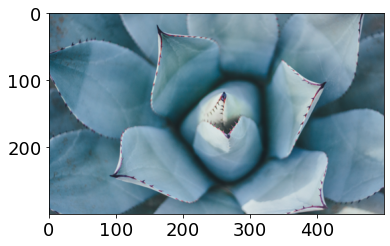

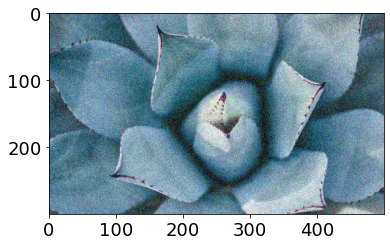

tensor([[0.9813, 0.0187]])
tensor([[3.4414e-04, 9.9966e-01]])


In [48]:
img= test_data[24]
clean, noise = img[0], img[1]
plt.imshow(np_to_pil(clean))
plt.show()
plt.imshow(np_to_pil(noise))
plt.show()
clean_out = net(np_to_torch(clean).cuda())
print(clean_out.detach().cpu())
noise_out = net(np_to_torch(noise).cuda())
print(noise_out.detach().cpu())